In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from warnings import filterwarnings

In [2]:
test_path ="test"
train_path ="train"
validation_path ="valid"

In [3]:
class_names = os.listdir('train')
print(f"Class names: {class_names}")

Class names: ['0', '1']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
generator = ImageDataGenerator(rescale=1/255)

In [6]:
train_data = generator.flow_from_directory( directory= train_path,
                                            target_size = (640,640),
                                            batch_size = 50,
                                            class_mode= 'binary',
                                            shuffle = True)
train_data

Found 2372 images belonging to 2 classes.


In [7]:
images, labels = next(train_data)

print("Shape of images:", images.shape)  
print("Shape of labels:", labels.shape) 

Shape of images: (50, 640, 640, 3)
Shape of labels: (50,)


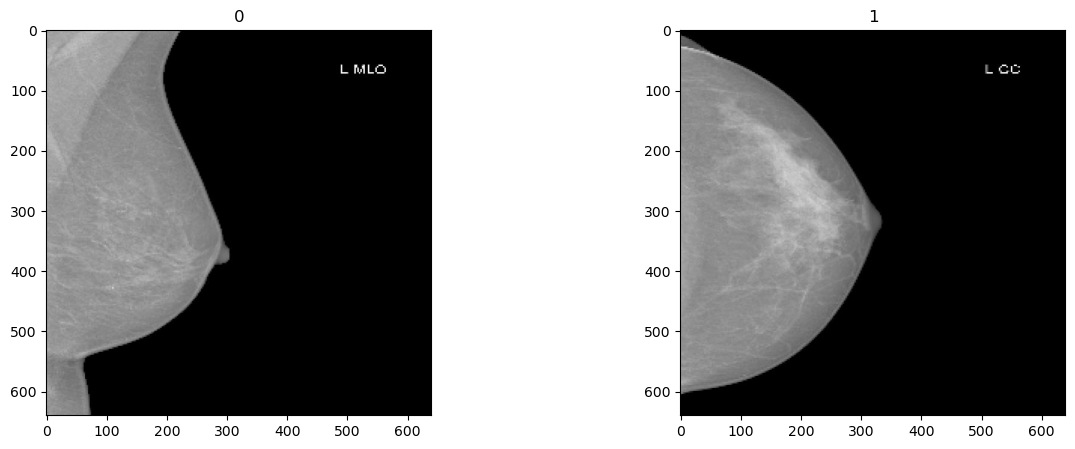

In [8]:
img1 = cv2.imread('5_640805896_png.rf.994310cc405370dfcb9ffa8f175afc80.jpg')
img2 = cv2.imread('106_76321767_png.rf.aa21c5be141d4ee32be960f2dfc4db8f.jpg')

# Check if the images are loaded properly
if img1 is None or img2 is None:
    print("One or both images failed to load")
else:
    plt.figure(1, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title('0')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.title('1')
    plt.show()


In [9]:
val_data = generator.flow_from_directory(directory = 'valid',
                                         target_size = (640,640),
                                         class_mode = 'binary',
                                         shuffle = True,
                                        )

Found 675 images belonging to 2 classes.


In [10]:
images, labels = next(val_data)

print("Shape of images: ", images.shape)
print("Labels", labels.shape)

Shape of images:  (32, 640, 640, 3)
Labels (32,)


In [11]:
test_data = generator.flow_from_directory(
                                        directory= test_path,
                                        target_size=(640, 640),
                                        batch_size=50,
                                        class_mode='binary'
                                    )
test_data

Found 336 images belonging to 2 classes.


In [12]:
#Model Build

model = Sequential()

# Input Layer
model.add(Conv2D(filters = 8, kernel_size= 3, padding='same',
                 activation = 'relu' ,input_shape =[640,640,3]))

# Pooling Layer
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(filters = 16, kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))


model.add(Conv2D(filters = 32, kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size =(3,3)))


model.add(Conv2D(filters = 64, kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size =(3,3)))


model.add(Conv2D(filters = 128, kernel_size = 3 , activation = 'relu'))
model.add(MaxPooling2D(pool_size =(3,3)))


# Flatten Layer 
model.add(Flatten())


# Fully Connected Layer
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# Output Layer

model.add(Dense(1, activation = 'sigmoid'))

C:\Users\Monisha\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 640, 640, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 320, 320, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 318, 318, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 106, 106, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 104, 104, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 34, 34, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,689 (705.82 KB)

 Trainable params: 180,689 (705.82 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [15]:
model_history = model.fit(train_data,
                          epochs = 10,
                          validation_data = val_data)

C:\Users\Monisha\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6443 - loss: 0.6566 - val_accuracy: 0.6548 - val_loss: 0.6336
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6789 - loss: 0.6202 - val_accuracy: 0.6548 - val_loss: 0.6541
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6831 - loss: 0.6271 - val_accuracy: 0.6548 - val_loss: 0.6240
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6844 - loss: 0.6089 - val_accuracy: 0.6533 - val_loss: 0.6518
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6784 - loss: 0.6008 - val_accuracy: 0.6385 - val_loss: 0.6432
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6801 - loss: 0.5987 - val_accuracy: 0.6533 - val_loss: 0.6592
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7052 - loss: 0.5784 - val_accuracy: 0.6533 - val_loss: 0.6300
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7024 - loss: 0.5769 - val_accuracy: 0.6726 - val_loss:

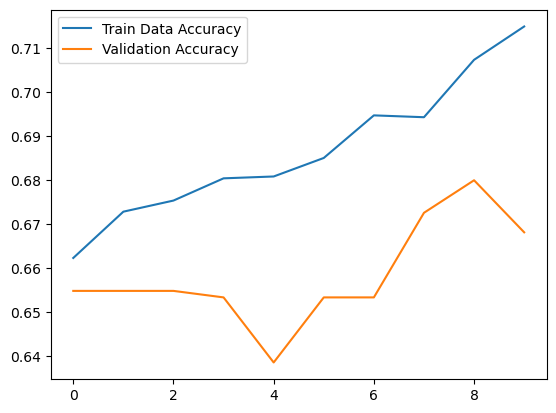

In [28]:
plt.plot(model_history.history['accuracy'], label = 'Train Data Accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - accuracy: 0.6351 - loss: 0.8379
Test accuracy: 0.6190476417541504


In [30]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation accuracy: {val_accuracy}')


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - accuracy: 0.6575 - loss: 0.8350
Validation accuracy: 0.6637036800384521


In [27]:
model.save("Deep_Learn.h5")

In [31]:
model.save('my_model.keras')

In [33]:
pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\monisha\anaconda3\lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.
